In [420]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import interp1d
import photon_spectrum
from time import process_time
from scipy.optimize import minimize, rosen, rosen_der, root, root_scalar
import warnings
import time
warnings.filterwarnings("ignore")
from urllib.request import urlopen
import astropy.io.fits as fits
from matplotlib.colors import LogNorm
import re
import healpy as hp
import importlib
import scipy as sp

filelist = ['Bremss_00320087_E_50-814008_MeV_healpix_128.fits']
energies = np.logspace(np.log10(.1), np.log10(1e6), num = 1000)

central_energies = np.array([1.22474487e+00, 1.54186244e+00, 1.94108981e+00, 2.44368729e+00,
       3.07642002e+00, 3.87298335e+00, 4.87579715e+00, 6.13826494e+00,
       7.72761772e+00, 9.72849432e+00, 1.22474487e+01, 1.54186244e+01,
       1.94108981e+01, 2.44368729e+01, 3.07642002e+01, 3.87298335e+01,
       4.87579715e+01, 6.13826494e+01, 7.72761772e+01, 9.72849432e+01,
       1.22474487e+02, 1.54186244e+02, 1.94108981e+02, 2.44368729e+02,
       3.07642002e+02, 3.87298335e+02, 4.87579715e+02, 6.13826494e+02,
       7.72761772e+02, 9.72849432e+02, 1.22474487e+03, 1.54186244e+03,
       1.94108981e+03, 2.44368729e+03, 3.07642002e+03, 3.87298335e+03,
       4.87579715e+03, 6.13826494e+03, 7.72761772e+03, 9.72849432e+03,
       1.22474487e+04, 1.54186244e+04, 1.94108981e+04, 2.44368729e+04,
       3.07642002e+04, 3.87298335e+04, 4.87579715e+04, 6.13826494e+04,
       7.72761772e+04, 9.72849432e+04, 1.22474487e+05, 1.54186244e+05,
       1.94108981e+05, 2.44368729e+05, 3.07642002e+05, 3.87298335e+05,
       4.87579715e+05, 6.13826494e+05, 7.72761772e+05, 9.72849431e+05,
       1.22474487e+06]) #in MeV


def nfw_profile_density(r, gamma = 1, massBH = 1.5e17):
    #need to eventually normalize to local density (4 GeV/cm^2)
    #also normalize to fraction of DM in black holes
    r_s = 20 #kpc
    #make sure r is in kpc
    rho_0 = get_rho0(massBH, gamma_forrho0 = gamma)
    rho = rho_0/(r/r_s)**(gamma)/((1+r/r_s)**(3-gamma)) #.4 GeV/cm^3
    return rho #number density #black holes per cm^3

def get_rho0(massBH = 1.5e17, gamma_forrho0 = 1):
    massBH_GeV = massBH*5.609e23 #to GeV from grams
    #calculating the initial rho_0
    r = 8.25 #kpc
    R_s = 20 #kpc
    rho_NFW = 0.4/massBH_GeV #BHs/cm^3, should be BHs/cm^3
    rho_0 = (r/R_s)**(gamma_forrho0)*rho_NFW*(1+r/R_s)**(3-gamma_forrho0)
    #print('rho_0: {}'.format(rho_0))
    return rho_0 #gives number density

def i_hate_trig(theta, l):
    R_GC = 8.25 #kpc
    theta_radians = theta/180*np.pi

    r = np.sqrt(l**2+R_GC**2-2*l*R_GC*math.cos(theta_radians))

    #B = np.arcsin(l*np.sin(theta)/r)
    #phi = 180-theta-B
    
    return r
    
    
def range_over_l(theta, massofBH = 1.5e17, gamma_here = 1):
    l = np.linspace(1, 60, 5000) #in kpc
        
    r = i_hate_trig(theta, l)
    #print(r)

    density = nfw_profile_density(r, massBH = massofBH, gamma = gamma_here)*5.61e26*massofBH #black holes/cm^3*mass of BH in MeV
    #print(density)

    
    return l, density

def get_deltaE_new(n):
    energybins = np.copy(central_energies)
    bins_in_lin = np.log10(energybins)[n]
    #spacing = 0.05691431 #old spacing
    spacing = 0.17609125905568124 #new spacing
    
    high_bin = 10**(bins_in_lin + spacing)
    low_bin = 10**(bins_in_lin - spacing)
    
    deltaE = np.abs(high_bin - low_bin)
    #print('delta E: {}'.format(deltaE))
    
    return high_bin, low_bin

def readfile(filename):
    """
    A simple function to read the maps of a given number n and given filename.
    """
    file_to_read = fits.open(filename)
    return file_to_read

def get_long_lat(longlatboo = True):

    hdu = fits.open(filelist[0])
    numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
    NSIDE = int(hdu[0].header['NSIDE'])
    degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = longlatboo)

    #all indices within 20 deg
    vec = hp.ang2vec(np.pi/2, 0)
    ipix_disc20 = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(20), inclusive = False)
    
    #all indices within 25 deg
    ipix_disc25 = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(25), inclusive = False)
    
    #the l and b values we want:
    
    testl = degrees[0][ipix_disc25]
    testb = degrees[1][ipix_disc25]
    
    #need to find the values of testl that are greater than 200 and subtract 360 from them
    
    where_large = np.argwhere(testl > 200)
    testl[where_large] = testl[where_large]-360

    return np.array(testl), np.array(testb), ipix_disc20, ipix_disc25

def get_j_factors(massBH = 1.5e17, gam = 1):

    btest, ltest, indices20, indices25 = get_long_lat()
    
    #thetas = np.linspace(-150, 150, 10000)
    
    thetas = np.sqrt(btest**2+ltest**2)
    
    integral = []
    
    #ls are in kpc
    
    for theta in thetas:
        #get the NFW density, and the lengths
        theta = np.abs(theta)
        ls, rho = range_over_l(theta, massofBH = massBH, gamma_here = gam) #kpc, black holes/cm^3
        n_BH = rho #*1e-4 #this also includes rho_0, can also use 1e-4 for PBH as DM 
        ls_incm = ls*3.086e21
        integral.append(np.trapz(n_BH, x = ls_incm)) #trapezoidal rule, with n_Bh on y axis and the length on x
    integral = np.asarray(integral) #in GeV/cm^2?
    
        
    return thetas, integral, indices20, indices25, btest, ltest #*lum/4/np.pi #units of GeV/cm^-2? 

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def log_interp1d(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind, fill_value="extrapolate")
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

def log_interp1d_theta(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind, fill_value = 'extrapolate')
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

def get_interpolated_theta(questioning_theta, function_theta):
    #questioning_theta = np.abs(questioning_theta
    
    try:
        return function_theta(questioning_theta)
    except ValueError:
        return 0
    
def interpolated_j(thetas, integral):
    thetas_above0 = np.where(thetas >= 0)
    
    
    new_integral = integral[thetas_above0]
    new_thetas = thetas[thetas_above0]
    
    func = interp1d(new_thetas, new_integral, fill_value = 0, bounds_error = False)
    
     
    return func


def get_dNdE(egamma_values, energy_index, gamma = 1, mass = 2e16, for_normals = False, fbh = 1):
    print('gamma ', gamma)
    print('mass of bh: {}'.format(mass))
    
    energiesforBH = np.logspace(np.log10(.05), np.log10(1e7), num = 1000) #in MeV
    
    #may need to integrate over this eventually
    thetas, integral, indices20, indices25, b, l = get_j_factors(massBH = mass, gam = gamma) #bhs*MeV/cm^2/BH
    #find number of black holes
    

    

    
    #eventually make it so this is only calculated once per mass_bh
    lum = (photon_spectrum.get_integral(egamma_values, mass_bh = mass)[1]) #units of photons per MeV per sec per BH
    
    #interpolate the luminosity
    
    lum_interp = log_interp1d(energiesforBH, lum, kind='linear') #integrate dn/dE in units of MeV
    
    high_bin, low_bin = get_deltaE_new(energy_index)
    print(high_bin)
    print(low_bin)
    
    lum_final = sp.integrate.quad(lum_interp, low_bin, high_bin)[0] #units of per second
    
    
    
    
    print('final luminosity:')
    print(lum_final)
    
    #now we need to add the integral back into the array where it was originally
    blank_array = np.empty(196608)
    blank_array[:] = 0
    
    #blank_array[indices25] = integral
    

    
    tempBH_ev = mass*5.61e26 #mass in GeV, converted then to MeV
    print('mass in MeV: {}'.format(tempBH_ev))
    

    #frac BH in units of % dark matter in black holes
    
    #func_jfactor = log_interp1d_theta(thetas, integral)
    
    final_js = []
    count = 0
    
    blank_array[indices25] = integral
    

    
    
    if for_normals:
        #need to only return the inner 20 degrees
        new_arr = blank_array[indices20]
        print(new_arr)
        print(np.nansum(new_arr)*4*np.pi/196608)
        print('-------')
        print('total rho dl: {}'.format(np.sum(new_arr)*4*np.pi/196608))
        return new_arr*lum_final/tempBH_ev/4/np.pi#/5938
    

    
    return blank_array*lum_final/tempBH_ev/4/np.pi #units of photons per str per sec per cm^2


In [421]:
energiesforBH = np.logspace(np.log10(.05), np.log10(1e7), num = 1000) #in MeV
#flux photon is in photons MeV^-1  per positron
#egamma_values = photon_spectrum.get_egammas(energiesforBH)

In [422]:
import acceptance_psf_eastrogam as aaa

acceptance_interp = aaa.get_acceptance_interp() #put in the energy in MeV!
angle_interp = aaa.get_angle_interp()
exposure_time = 4.1e8 #13 years

In [423]:
def get_deltaE(n):
    energybins = central_energies
    bins_in_lin = np.log10(energybins)[n]
    #spacing = 0.05691431 #old spacing
    spacing = 0.17609125905568124 #new spacing
    
    high_bin = 10**(bins_in_lin + spacing)
    low_bin = 10**(bins_in_lin - spacing)
    
    deltaE = np.abs(high_bin - low_bin)
    #print('delta E: {}'.format(deltaE))
    
    return deltaE

deltae = []

for n in range(0, len(central_energies)):
    delte = get_deltaE(n)
    deltae.append(delte)
    
acceptances = []
for energy_here in central_energies:
    acceptance_forpoisson = acceptance_interp(energy_here) #in cm^2*str
    acceptances.append(acceptance_forpoisson)

In [424]:
get_dNdE(egamma_values, 0, gamma = 1.6, mass = 2e16, for_normals = True, fbh = 4e-4)

gamma  1.6
mass of bh: 2e+16
1.837117305
0.81649658
final luminosity:
9.092455937382618e+17
mass in MeV: 1.122e+43
[7.46968898e+25 7.46497437e+25 7.45087956e+25 ... 7.42755015e+25
 7.45087956e+25 7.46497437e+25]
4.943534917817686e+25
-------
total rho dl: 4.943534917817686e+25


array([0.48170483, 0.4814008 , 0.48049185, ..., 0.47898739, 0.48049185,
       0.4814008 ])

In [387]:
arrayx = [0, 1, 1, 2, 2, 3]
arrayy = [1, 1, 1, 1, 1, 1]
print(np.trapz(arrayy, x = arrayx))

3.0


In [412]:
def evap_norms(egamma_values, gam, massbh, f_bh):
    energies = np.copy(central_energies)
    templates = []
    temp = []
    deltaomega = 4*np.pi/196608 #i think this should maybe still be total bins in whole image pre-20?
    #eavporating black holes
    dmevap_temp = []
    dmevap_tot = []
    for index in range(0, 10):
        energybin = central_energies[index]
        print('energy: {}'.format(energybin))
        bins_in_lin = np.log10(energybin)
    
        data50 = get_dNdE(egamma_values, index, gamma = gam, mass = massbh, for_normals = True, fbh = f_bh) #units of photons cm^-2 str^-1 per sec 
        #need to cut this to be inner 20 degrees
        
        
        #dm_temp.append(np.nansum(data50))
        dmevap_temp.append(np.nansum(data50)*deltaomega) #13 years * .85 m^2 * .2, return in photons /cm^2 /sec
        print(np.nansum(data50)*deltaomega)
        print('---------------------------------')
    dmevap_tot.append(np.asarray(dmevap_temp)/.38*f_bh) #photons per pixel?
    return dmevap_tot
    

In [413]:
blackhole_norms = evap_norms(egamma_values, 1.6, 2e16, 4e-4)

gamma  1.6
mass of bh: 2e+16
1.837117305
0.81649658
final luminosity:
9.092455937382618e+17
mass in MeV: 1.122e+43
[7.46968898e+25 7.46497437e+25 7.45087956e+25 ... 7.42755015e+25
 7.45087956e+25 7.46497437e+25]
4.943534917817686e+25
-------
0.3187983685577604
---------------------------------
gamma  1.6
mass of bh: 2e+16
2.31279366
1.0279082933333334
final luminosity:
1.356033741127993e+18
mass in MeV: 1.122e+43
[7.46968898e+25 7.46497437e+25 7.45087956e+25 ... 7.42755015e+25
 7.45087956e+25 7.46497437e+25]
4.943534917817686e+25
-------
0.47545057942323576
---------------------------------
gamma  1.6
mass of bh: 2e+16
2.911634715
1.2940598733333335
final luminosity:
1.911338354808416e+18
mass in MeV: 1.122e+43
[7.46968898e+25 7.46497437e+25 7.45087956e+25 ... 7.42755015e+25
 7.45087956e+25 7.46497437e+25]
4.943534917817686e+25
-------
0.6701506759791909
---------------------------------
gamma  1.6
mass of bh: 2e+16
3.665530935
1.6291248600000001
final luminosity:
2.3047801362132536e+1

In [414]:
print(get_deltaE(0))
print(central_energies[0])

1.0206207250000001
1.22474487


(1000000000000000.0, 1e+22)

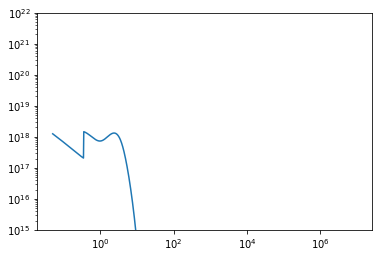

In [390]:
lum = (photon_spectrum.get_integral(egamma_values, mass_bh = 2e16)[1])

plt.plot(energiesforBH, lum)

plt.yscale('log')
plt.xscale('log')
plt.ylim(1e15, 1e22)


In [391]:
print((blackhole_norms))

[array([ 4160.54356886,  6204.96541271,  8745.93900127, 10546.25751216,
       10258.66015829,  7836.83735755,  4505.25332755,  1830.01498322,
         515.7003877 ,   100.8749406 ])]


10


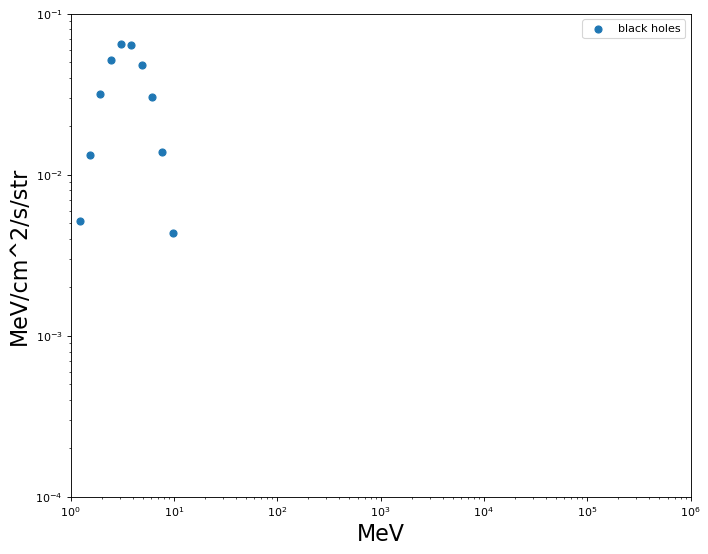

In [392]:


units = np.array(np.array(deltae)*exposure_time/196608*np.array(acceptances))[0:10] #units of MeV*s/pixel*str
print(len(units))

fntsz=20
plt.close()
plt.figure(figsize=(10, 8), dpi=80)

plt.scatter(central_energies[0:10], (blackhole_norms[0]/units*(central_energies**2)[0:10]), label = 'black holes', s = 40)
plt.scatter(central_energies[0:10], (blackhole_norms[0]/units*(central_energies**2)[0:10]), label = 'black holes', s = 40)


plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-10, 1e-1)
plt.ylim(1e-4, 1e-1)
plt.xlim(1e0, 1e6)
plt.legend()